In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Load and preprocess data
housing_data = fetch_california_housing()
X = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
y = pd.DataFrame(housing_data.target, columns=['Target'])

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
y = y.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [3]:
# Fixed Learning Rate Comparison
seed = 42
lr_list = [0.1, 0.01, 0.001, 0.0001]
fixed_mse = {}

for lr in lr_list:
    model = MLPRegressor(hidden_layer_sizes=(),
                         activation='identity',
                         solver='sgd',
                         learning_rate='constant',
                         learning_rate_init=lr,
                         batch_size=X_train.shape[0],
                         max_iter=100,
                         shuffle=False,
                         random_state=seed,
                         tol=0.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fixed_mse[str(lr)] = [mean_squared_error(y_test, y_pred) for _ in range(100)]
    final_test_mse = mean_squared_error(y_test, y_pred)
    print("Final MSE on Test Set:", final_test_mse)

Final MSE on Test Set: 0.5630316758898313
Final MSE on Test Set: 0.7412738421926192
Final MSE on Test Set: 1.3350169167831742
Final MSE on Test Set: 5.891437250289956


In [4]:
# MAB Training with data collection
act = [0.1, 0.0001]
act_labels = ['0.1', '0.0001']
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.001
epsilon_decay = 0.1
reward = [1e25 for _ in act]
steps = 100

selected_lr = []
explore_flags = []
epsilon_values = []
rewards_history = [[1e25] for _ in act]
mse_history = {'MAB': [], 'Fixed_0.1': fixed_mse['0.1'], 'Fixed_0.0001': fixed_mse['0.0001']}
coef_trajectory = []

model = MLPRegressor(hidden_layer_sizes=(),
                     activation='identity',
                     solver='sgd',
                     learning_rate='constant',
                     learning_rate_init=act[0],
                     batch_size=X_train.shape[0],
                     max_iter=1,
                     warm_start=True,
                     shuffle=False,
                     random_state=seed,
                     tol=0.0)

model.fit(X_train, y_train)

for step in range(steps):
    if np.random.rand() < epsilon:
        idx = np.random.choice(len(act))
        explore_flags.append(True)
    else:
        idx = np.argmin(reward)
        explore_flags.append(False)

    model.learning_rate_init = act[idx]
    selected_lr.append(act[idx])
    epsilon_values.append(epsilon)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    reward[idx] = (1 - 0.9) * reward[idx] + 0.9 * mse
    mse_history['MAB'].append(mse)

    for i in range(len(act)):
        rewards_history[i].append(reward[i])

    coef_trajectory.append([model.coefs_[0].ravel()[0], model.coefs_[0].ravel()[1], mse])

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * step)

In [5]:
# Final test evaluation
y_pred_test = model.predict(X_test)
final_test_mse = mean_squared_error(y_test, y_pred_test)
print("Final MSE on Test Set:", final_test_mse)

Final MSE on Test Set: 0.5513624011769218


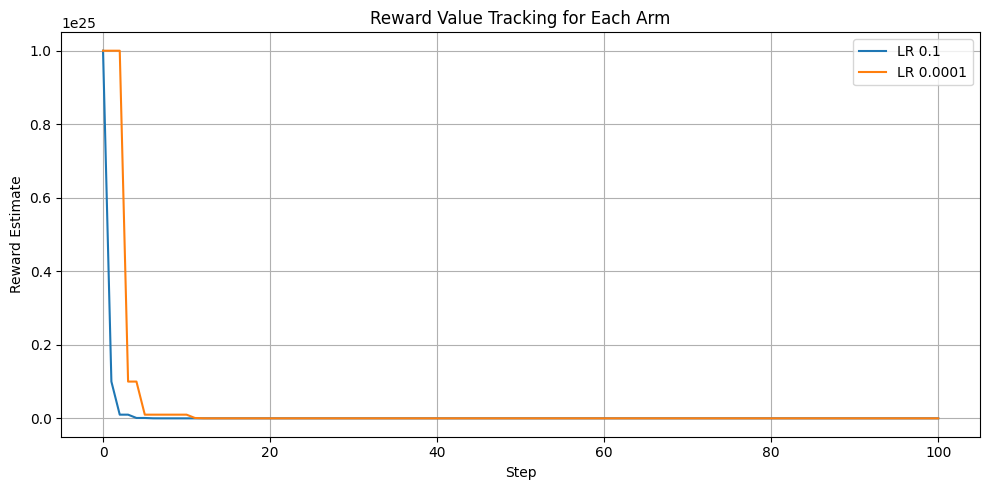

In [6]:
# Plot: Reward Value Tracking for Each Arm
plt.figure(figsize=(10, 5))
for i, r in enumerate(rewards_history):
    plt.plot(r, label=f"LR {act[i]}")
plt.xlabel("Step")
plt.ylabel("Reward Estimate")
plt.title("Reward Value Tracking for Each Arm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

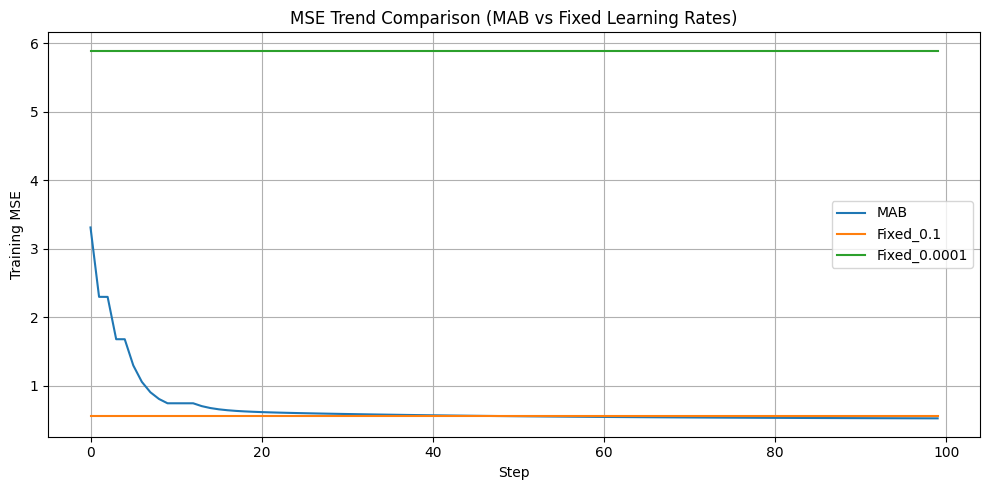

In [7]:
# Plot: MSE Trend Comparison
plt.figure(figsize=(10, 5))
for key, mse_list in mse_history.items():
    plt.plot(mse_list, label=key)
plt.xlabel("Step")
plt.ylabel("Training MSE")
plt.title("MSE Trend Comparison (MAB vs Fixed Learning Rates)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

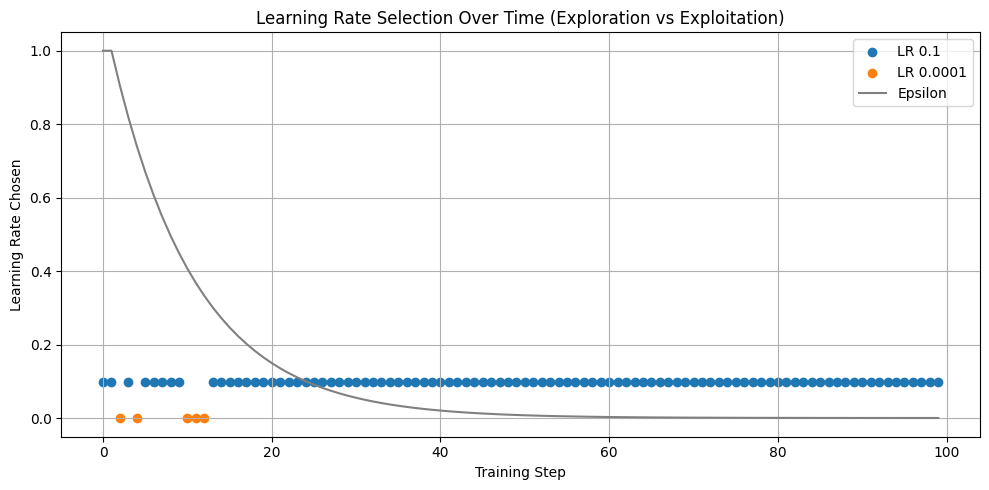

In [8]:
# Plot: Learning Rate Selection Over Time
plt.figure(figsize=(10, 5))
for i, lr in enumerate(act):
    marker = 'o'
    color = 'tab:blue' if i == 0 else 'tab:orange'
    idxs = [j for j, x in enumerate(selected_lr) if x == lr]
    plt.scatter(idxs, [lr]*len(idxs), marker=marker, color=color, label=f"LR {lr}")
plt.plot(epsilon_values, color='gray', label='Epsilon')
plt.xlabel("Training Step")
plt.ylabel("Learning Rate Chosen")
plt.title("Learning Rate Selection Over Time (Exploration vs Exploitation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()